# San Ramon Rents Using MXNet

In this tutorial we'll walk through how to predict San Ramon rents using *linear regression* with MXNet.

The rents data is based on <https://sfbay.craigslist.com>


## San Ramon, California

<img height=500 src="https://cdn.tollbrothers.com/communities/12871/images/2880BiancoExterior_920.jpg">

## Prerequisites

To complete this tutorial, we need:  

- jupyter
- scikitlearn
- pandas
- numpy
- matplotlib
- mxnet

## Imports

To begin, the following code imports the necessary packages we'll need for this exercise.

In [1]:
import mxnet as mx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fix the random seed
mx.random.seed(2727)

import logging
logging.getLogger().setLevel(logging.DEBUG)

## Preparing the Data

In MXNet, data is input via **Data Iterators**. Here we will illustrate
how to encode a dataset into an iterator that MXNet can use. The data used in the example is made up of 2D data points with corresponding integer labels. 

In [3]:
# Get the rents as a data frame.
rents_csv = "/Users/asimjali/g/projects/aws-sage/san-ramon-rents.csv"
df = pd.read_csv(rents_csv)

In [4]:
# Let's take a look at the data.
df.describe()

,rent,br,ft2
count,256.000000,256.000000,256.000000
mean,2787.437500,2.175781,1179.835938
std,878.821057,0.943689,642.734242
min,1800.000000,1.000000,400.000000
25%,2300.000000,2.000000,800.000000
50%,2575.000000,2.000000,953.000000
75%,2961.250000,3.000000,1253.500000
max,9500.000000,5.000000,5200.000000


In [5]:
# Split the data into features (X) and label (y)
label_column = 'rent'
X = df.drop(label_column, axis=1)
y = df[label_column]

# Split data set into training and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Since ft2 is much larger than br we can scale to standardize the features.
scale_features = True
if scale_features:
    # Scale features automatically extracts feature numpy arrays.
    from sklearn import preprocessing
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test = std_scale.transform(X_test)
else:
    # Extract feature numpy arrays.
    X_train = X_train.values
    X_test = X_test.values

# Extract label numpy arrays.
y_train = y_train.values
y_test = y_test.values
        
# How many examples do we train on at a time.
batch_size = 30

Once we have the data ready, we need to put it into an iterator and specify
parameters such as `batch_size` and `shuffle`. `batch_size` specifies the number
of examples shown to the model each time we update its parameters and `shuffle`
tells the iterator to randomize the order in which examples are shown to the model.

In [6]:
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(X_test, y_test, batch_size, shuffle=False, label_name='lin_reg_label')

In the above example, we have made use of `NDArrayIter`, which is useful for iterating
over both numpy ndarrays and MXNet NDArrays. In general, there are different types of iterators in
MXNet and you can use one based on the type of data you are processing.
Documentation for iterators can be found [here](http://mxnet.io/api/python/io/io.html).

## MXNet Classes

1. **IO:** The IO class as we already saw works on the data and carries out
   operations such as feeding data in batches and shuffling.
   
2. **Symbol:** The actual MXNet neural network is composed using symbols. MXNet has
   different types of symbols, including variable placeholders for input data,
   neural network layers, and operators that manipulate NDArrays.

3. **Module:** The module class in MXNet is used to define the overall computation.
	It is initialized with the model we want to train, the training inputs (data and labels)
	and some additional parameters such as learning rate and the optimization
	algorithm to use.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks 
and make up various components of the model. Symbols are used to define:

1. **Variables:** A variable is a placeholder for future data. This symbol is used
   to define a spot which will be filled with training data/labels in the future
   when we commence training.
2. **Neural Network Layers:** The layers of a network or any other type of model are
   also defined by Symbols. Such a symbol takes one or more previous symbols as
   inputs, performs some transformations on them, and creates one or more outputs.
   One such example is the `FullyConnected` symbol which specifies a fully connected
   layer of a neural network.
3. **Outputs:** Output symbols are MXNet's way of defining a loss. They are
   suffixed with the word "Output" (eg. the `SoftmaxOutput` layer). You can also
   [create your own loss function](https://github.com/dmlc/mxnet/blob/master/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function).
   Some examples of existing losses are: `LinearRegressionOutput`, which computes
   the l2-loss between it's input symbol and the labels provided to it;
   `SoftmaxOutput`, which computes the categorical cross-entropy.

The ones described above and other symbols are chained together with the output of
one symbol serving as input to the next to build the network topology. More information
about the different types of symbols can be found [here](http://mxnet.io/api/python/symbol/symbol.html).

In [7]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. `FullyConnected`: The fully connected symbol represents a fully connected layer
   of a neural network (without any activation being applied), which in essence,
   is just a linear regression on the input attributes. It takes the following
   parameters:

   - `data`: Input to the layer (specifies the symbol whose output should be fed here)
   - `num_hidden`: Number of hidden neurons in the layer, which is same as the dimensionality
     of the layer's output

2. `LinearRegressionOutput`: Output layers in MXNet compute training loss, which is
	the measure of inaccuracy in the model's predictions. The goal of training is to minimize the
	training loss. In our example, the `LinearRegressionOutput` layer computes the *l2* loss against
	its input and the labels provided to it. The parameters to this layer are:

   - `data`: Input to this layer (specifies the symbol whose output should be fed here)
   - `label`: The training labels against which we will compare the input to the layer for calculation of l2 loss

## Visualize Network

We can visualize the network we created by plotting it:

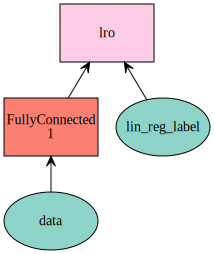

In [8]:
mx.viz.plot_network(symbol=lro)

**Note on naming convention:** the label variable's name should be the same as the
`label_name` parameter passed to your training data iterator. The default value of
this is `softmax_label`, but we have updated it to `lin_reg_label` in this
tutorial as you can see in `Y = mx.symbol.Variable('lin_reg_label')` and
`train_iter = mx.io.NDArrayIter(..., label_name='lin_reg_label')`.


## Module

Finally, the network is input to a *Module*, where we specify the symbol
whose output needs to be minimized (in our case, `lro` or the `lin_reg_output`), the
learning rate to be used while optimization and the number of epochs we want to
train our model for.

In [9]:
# Network structure.
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']
)

In [10]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label) 
init = mx.init.Uniform(0.1)
model.init_params(init)

## Training the model

Once we have defined the model structure, the next step is to train the
parameters of the model to fit the training data. This is accomplished using the
`fit()` function of the `Module` class.

Speedometer determines how often we get a callback during training with error data. We will be called every 2 batches if the second argument is 2.

In [ ]:
model.fit(train_iter, eval_iter,
            optimizer = "adam",
            optimizer_params = {'learning_rate': 8.0},
            num_epoch=800,
            eval_metric='rmse',
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

## Using a trained model: (Testing and Inference)

Once we have a trained model, we can do a couple of things with it - we can either
use it for inference or we can evaluate the trained model on test data. The latter is shown below:

RMSE = 809.212641343
MAPE = 18.96%
Accuracy = 81.04%


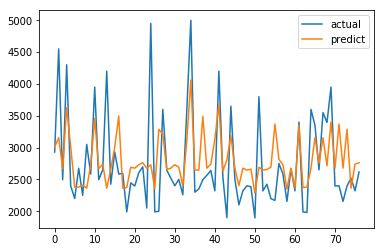

In [12]:
# Let's find out how we did.
y_predict = model.predict(eval_iter).asnumpy()

# RMSE is Root Mean Square Error.
rmse = np.sqrt(np.mean((y_predict - y_test)**2))
print('RMSE = {}'.format(rmse))

# MAPE is Median Absolute Percentage Error.
mape = 100 * np.median(np.abs(y_test - y_predict) / y_test)
print('MAPE = {}%'.format(round(mape, 2)))

# Accuracy is the opposite of MAPE.
accuracy = 100 - mape
print('Accuracy = {}%'.format(round(accuracy, 2)))

# Plot the predictions against the actual values.
plt.plot(np.array(y_test), label='actual')
plt.plot(y_predict, label='predict')
plt.legend()
plt.show()